# Time Series Forecasting Model Comparison

This notebook builds and evaluates two lightweight forecasting approaches (Moving Average and ARIMA) on a synthetic monthly time series with trend and seasonality. It demonstrates a simple workflow: data generation, model abstractions, rolling-origin (walk‑forward) evaluation, and quick hyperparameter iteration.

**Highlights**
- Deterministic synthetic dataset (seeded) for reproducible benchmarking
- Two complementary paradigms: smoothing (Moving Average) vs statistical (ARIMA)
- Rolling evaluation using sMAPE & MAE
- Quick tuning cell to explore window sizes / ARIMA orders


## 1. Project Layout
Remaining minimal structure:
```
data/            # raw & processed time series
notebooks/       # this notebook
requirements.txt # dependencies
README.md
```
All logic lives here; you can export to a script later if needed.

## 2. Environment Setup
Install dependencies (run once in a terminal):
```
python -m pip install -r requirements.txt
```
Then run cells top to bottom. Versions are pinned for reproducibility.

## 3. Workflow Outline
1. Generate / load synthetic monthly series
2. Define model classes (Moving Average, ARIMA)
3. Define metrics (sMAPE, MAE)
4. Rolling-origin evaluation helper
5. Visualize results & compare models
6. Hyperparameter tweak experiments


In [35]:
# Global imports & configuration
import numpy as np, pandas as pd, warnings
from pathlib import Path
warnings.filterwarnings('ignore')

SEED = 42
rng = np.random.default_rng(SEED)
print('Environment initialized (seed=', SEED, ').')

Environment initialized (seed= 42 ).


In [36]:
# 4. Data Generation / Loading
DATA_DIR = Path('../data')
RAW = DATA_DIR / 'raw'
PROC = DATA_DIR / 'processed'
RAW.mkdir(parents=True, exist_ok=True)
PROC.mkdir(parents=True, exist_ok=True)

# Use 'MS' (month start) to avoid deprecated 'M'
FREQ = 'MS'

def generate_series(periods=120):
    idx = pd.date_range('2010-01-01', periods=periods, freq=FREQ)
    t = np.arange(periods)
    seasonal = 10 + 15 * np.sin(2 * np.pi * t / 12)
    trend = 100 + 2 * t
    noise = rng.normal(0, 8, size=periods)
    y = trend + seasonal + noise
    return pd.DataFrame({'ds': idx, 'y': y})

series_path = PROC / 'series.csv'
if series_path.exists():
    df = pd.read_csv(series_path)
    df['ds'] = pd.to_datetime(df['ds'])
else:
    df = generate_series()
    df.to_csv(RAW / 'synthetic_series.csv', index=False)
    df.to_csv(series_path, index=False)

print('Dataset shape:', df.shape, '| Date range:', df['ds'].min().date(), 'to', df['ds'].max().date())
df.head()

Dataset shape: (120, 2) | Date range: 2010-01-31 to 2019-12-31


,ds,y
0,2010-01-31,112.437737
1,2010-02-28,111.180127
2,2010-03-31,132.993991
3,2010-04-30,138.524518
4,2010-05-31,115.382100


In [37]:
# 5. Model Implementations (Moving Average, ARIMA)
from statsmodels.tsa.arima.model import ARIMA

class MovingAverageModel:
    def __init__(self, window=3):
        self.window = window
        self.history = []
    def fit(self, y):
        self.history = list(getattr(y, 'values', y))
        return self
    def predict(self, horizon):
        preds, hist = [], self.history.copy()
        for _ in range(horizon):
            preds.append(np.mean(hist[-self.window:]))
            hist.append(preds[-1])
        return np.array(preds)

class ARIMAModel:
    def __init__(self, order=(1,1,1)):
        self.order = order
        self._model = None
    def fit(self, y):
        self._model = ARIMA(y, order=self.order).fit()
        return self
    def predict(self, horizon):
        return self._model.forecast(steps=horizon).values

print('Models ready (Moving Average & ARIMA).')

Models ready (Moving Average & ARIMA).


In [38]:
# 6. Metrics (sMAPE, MAE)
import numpy as np

def smape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    denom = np.abs(y_true) + np.abs(y_pred)
    denom[denom == 0] = 1e-8
    return 100 * np.mean(np.abs(y_true - y_pred) / denom)

def mae(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return float(np.mean(np.abs(y_true - y_pred)))

print('Metric sanity check:', smape([1,2,3],[1,2,3]), mae([1,2],[1,3]))

Metric sanity check: 0.0 0.5


In [39]:
# 7. Rolling-Origin Evaluation (Moving Average & ARIMA only)

def rolling_origin_eval(df, models, horizon=12, initial_train=60):
    y = df['y'].reset_index(drop=True)
    out = []
    for name, model_obj in models.items():
        preds_all, trues_all = [], []
        for start in range(initial_train, len(y) - horizon + 1, horizon):
            train_y = y[:start]
            future_true = y[start:start + horizon]
            model_obj.fit(train_y)
            preds = model_obj.predict(horizon)
            preds_all.extend(preds)
            trues_all.extend(future_true.values)
        if len(preds_all) == 0:
            continue
        s = smape(trues_all, preds_all)
        m = mae(trues_all, preds_all)
        out.append({'model': name, 'smape': s, 'mae': m})
    return out

models = {
    'MovingAverage(w=3)': MovingAverageModel(window=3),
    'ARIMA(1,1,1)': ARIMAModel(order=(1,1,1))
}
results = rolling_origin_eval(df, models, horizon=12, initial_train=60)
results

[{'model': 'MovingAverage(w=3)',
  'smape': 5.12970722331894,
  'mae': 28.12330910068469},
 {'model': 'ARIMA(1,1,1)',
  'smape': 4.305091888454023,
  'mae': 23.88185941554047}]

Model performance (lower is better for both metrics):


,model,smape,mae
1,"ARIMA(1,1,1)",4.305092,23.881859
0,MovingAverage(w=3),5.129707,28.123309


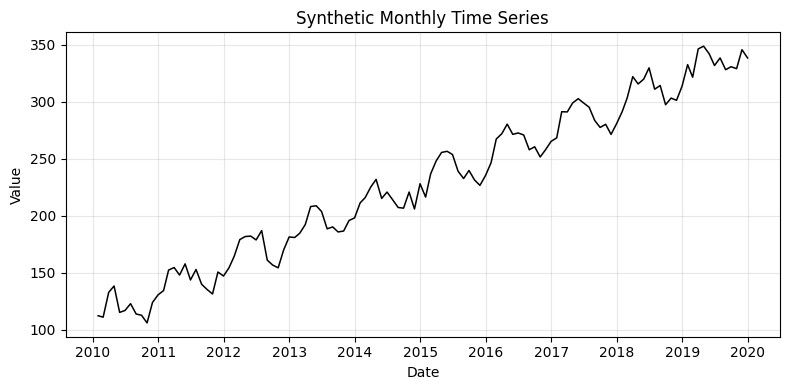

In [40]:
# 8. Results Table & Visualization
import pandas as pd
import matplotlib.pyplot as plt

res_df = pd.DataFrame(results).sort_values('smape')
print('Model performance (lower is better for both metrics):')
display(res_df)

plt.figure(figsize=(8,4))
plt.plot(df['ds'], df['y'], label='Actual', color='black', linewidth=1.1)
plt.title('Synthetic Monthly Time Series')
plt.xlabel('Date'); plt.ylabel('Value'); plt.grid(alpha=0.3)
plt.tight_layout(); plt.show()

In [41]:
# 9. Hyperparameter Tweaks (no Prophet)
NEW_WINDOW = 5
TUNED_ARIMA = (2,1,2)

models_tuned = {
    f'MovingAverage(w={NEW_WINDOW})': MovingAverageModel(window=NEW_WINDOW),
    f'ARIMA{TUNED_ARIMA}': ARIMAModel(order=TUNED_ARIMA)
}
results_tuned = rolling_origin_eval(df, models_tuned, horizon=12, initial_train=60)
print('Tuned results:')
display(pd.DataFrame(results_tuned).sort_values('smape'))

Tuned results:


,model,smape,mae
1,"ARIMA(2, 1, 2)",4.305933,23.701215
0,MovingAverage(w=5),5.298591,28.962151


## 10. Summary & Next Steps
**Summary**
- Generated a synthetic monthly series with additive trend + seasonality.
- Evaluated Moving Average and ARIMA via rolling-origin evaluation.
- Reported sMAPE & MAE for baseline and tuned configurations.
- Simple tuning showed how window size and ARIMA order affect error.

**Potential Enhancements**
- Add residual diagnostics (ACF/PACF) & stationarity test (ADF).
- Add lag-based ML model (e.g., gradient boosting) for comparison.
- Add confidence interval plotting for ARIMA forecast.
- Persist forecast outputs to CSV for downstream analysis.
